In [1]:
#Python 3.11.2
#Import packages
import scipy.integrate as scipy
import numpy as np
import pylab as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import json # for pretty printing

Initializing the population size, the initial conditions and the number of patches:

In [2]:
# Number of patches
n = 19

 # vector of population sizes with lenght n
N = np.array([204  # Bromma
              , 217  # Oja
              , 1895  # S Maria Ystad 1749
              , 554  # Valleberga
              , 693  # S Kopinge
              , 403  # Horups
              , 582  # Bjäresjö 1780
              , 716  # Villie 1749
              , 418  # Snårestad 1775
              , 519  # Skårby 1749
              , 262  # Hammenhögs 1749
              , 560  # Glemminge 1775
              , 236  # Balkåkra 1775
              , 334  # Baldringe 1749
              , 299  # Ovraby
              , 761  # Sövestads 1749
              , 776  # Löderups 1749
              , 951  # Borrby 1775
              , 358  # Tosterups 1775
              ]) 

# Initial conditions for each patch

I0 = np.zeros(n)  # vector of initial infecteds with lenght n
I0[0] = 1.0  # the first element of the I0 vector is set to 1

S0 = np.zeros(n)  # vector of initial susceptibles with lenght n
for i in range(n):
    S0[i] = N[i] - I0[i]

R0 = np.zeros(n)  # vector of initial removeds with lenght n
D0 = np.zeros(n)  # vector of initial deaths with lenght n

#print(S0,I0,R0,D0)

In [3]:
# Defining the transmission rate matrix as a function of two parameters

def TransmissionRateMatrix(beta: float, p: float)-> np.ndarray:
    return(
        np.array([
            [beta, p, 0, 0, 0, 0, p, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 0, 0],
            [p, beta, p, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, p, beta, 0, p, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, beta, 0, p, 0, 0, 0, 0, 0, p, 0, 0, 0, 0, p, 0, 0],
            [0, 0, p, 0, beta, 0, 0, 0, 0, 0, 0, p, 0, 0, p, 0, 0, 0, p],
            [0, 0, 0, p, 0, beta, 0, 0, 0, 0, p, p, 0, 0, 0, 0, p, p, 0],
            [p, 0, 0, 0, 0, 0, beta, 0, 0, p, 0, 0, p, 0, 0, p, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, beta, 0, p, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, beta, 0, 0, 0, p, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, p, p, 0, beta, 0, 0, p, 0, 0, p, 0, 0, 0],
            [0, 0, 0, 0, 0, p, 0, 0, 0, 0, beta, 0, 0, 0, 0, 0, 0, p, 0],
            [0, 0, 0, p, p, p, 0, 0, 0, 0, 0, beta, 0, 0, 0, 0, 0, 0, p],
            [0, 0, 0, 0, 0, 0, p, 0, p, p, 0, 0, beta, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, beta, 0, p, 0, 0, 0],
            [0, 0, 0, 0, p, 0, 0, 0, 0, 0, 0, 0, 0, 0, beta, 0, 0, 0, p],
            [p, 0, 0, 0, 0, 0, p, 0, 0, p, 0, 0, 0, p, 0, beta, 0, 0, 0],
            [0, 0, 0, p, 0, p, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, beta, p, 0],
            [0, 0, 0, 0, 0, p, 0, 0, 0, 0, p, 0, 0, 0, 0, 0, p, beta, 0],
            [0, 0, 0, 0, p, 0, 0, 0, 0, 0, 0, p, 0, 0, p, 0, 0, 0, beta]
     ] )
    )
    
print(TransmissionRateMatrix(2, 1)[0][2])
size = TransmissionRateMatrix(2, 1).shape
print(size)


0
(19, 19)


Generating the seasonality function

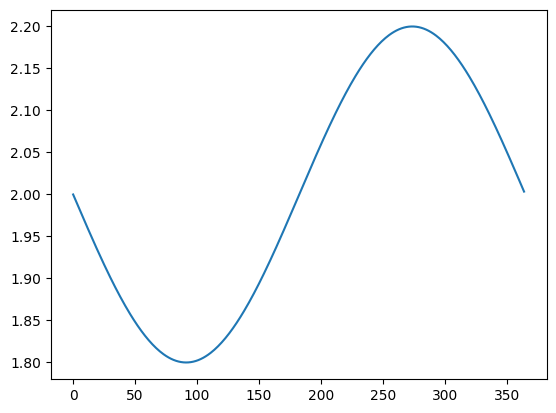

In [18]:

def seasonal_transmission_rate(t, beta_0, beta_1, a, frequency=1/(365*1.0)):
    return beta_0 * (1 + beta_1 * np.sin((2 * np.pi)* frequency * t - a))
    

# Generate some example data with seasonality
t = np.arange(0, 365,1)
beta_0 = 2
beta_1 = -0.1
a = 0

# Plot beta 
plt.plot(t, seasonal_transmission_rate(t, beta_0, beta_1, a))
plt.show()



Generating the differential equations

In [6]:
def SIRD_model(y, t,
               model_parameters: tuple[dict]):

    parameters = model_parameters[0]
    beta: float = parameters['beta'] 
    p: float = parameters['p']
    gamma: float = parameters['gamma']
    mu: float = parameters['mu']
    N = parameters['N']
    n: int = parameters['n']

    S = defaultdict(float)
    I = defaultdict(float)
    R = defaultdict(float)
    D = defaultdict(float)

    vars = tuple(sum([[S[i], I[i], R[i], D[i]] for i in range(n)], []))
    vars = y

   # Choosing the corresponding output for each subpopulation
    def entryS(i):
        return vars[4 * i]

    def entryI(i):
        return vars[4 * i + 1]

    def entryR(i):
        return vars[4 * i + 2]

    def entryD(i):
        return vars[4 * i + 3]

    # Initializando the directory for each subpopulation
    dS = {}
    dI = {}
    dR = {}
    dD = {}

    # Defining the seasonal transmission rate
    def seasonal_transmission_rate(t, beta_0 = 1.5, beta_1 = 0.1, a = 120, frequency = 1/(360*1.0)):
        return beta_0 * (1 + beta_1 * np.sin((2 * np.pi) * frequency * t - a))

    # Defining the differential equations for each subpopulation
    for i in range(n):
        dS[i] = (- (entryS(i) / (N[i]*1.0)) *
                 sum(TransmissionRateMatrix(beta, p)[i][j] *
                    seasonal_transmission_rate(t) * entryI(j) 
                    for j in range(n))
                 )
        dI[i] = ((entryS(i) / (N[i]*1.0)) * 
                  sum(TransmissionRateMatrix(beta, p)[i][j] *
                      seasonal_transmission_rate(t) * entryI(j) 
                      for j in range(n)) 
                  - gamma * entryI(i)   
                )
        dR[i] = gamma * mu * entryI(i)
        dD[i] = gamma * (1 - mu) * entryI(i)

    derivates = sum([[dS[i], dI[i], dR[i], dD[i]] for i in range(n)], [])
    return derivates   # For odeint


def generate_sol(genInput: dict) -> dict:
    model = genInput['model']
    init = genInput['init']
    beta = genInput['beta']
    gamma = genInput['gamma']
    mu = genInput['mu']
    n = genInput['n']
    p = genInput['p']
    N = genInput['N']
    T = genInput['T']

    # Initial conditions vector for the metapopulation model. len(initConditions) = 4*n
    initConditions = tuple(sum(
        [[init['S'][i], init['I'][i], init['R'][i], init['D'][i]] for i in range(n)], []))

    # Time vector
    t = np.linspace(0, T, T+1)

    # Computing the numerical solution
    solution = scipy.odeint(model, initConditions, t, args=((genInput,),))

    indexVar = {}
    indexVar['S'] = 0
    indexVar['I'] = 1
    indexVar['R'] = 2
    indexVar['D'] = 3

    def varSol(patch, var):
        return solution[:, 4*patch + indexVar[var]]

    return {'S': {patch: varSol(patch, 'S') for patch in range(n)},
            'I': {patch: varSol(patch, 'I') for patch in range(n)},
            'R': {patch: varSol(patch, 'R') for patch in range(n)},
            'D': {patch: varSol(patch, 'D') for patch in range(n)},
            'N': N,
            'init': init,
            'beta': beta,
            'gamma': gamma,
            'mu': mu,
            't': t,
            'n': n,
            'p': p,
            'model': model,
            'raw_solution': solution}


Model_test = {'model': SIRD_model,
              'init': {
                  'S': S0,
                  'I': I0,
                  'R': R0,
                  'D': D0,
              },  # defining the initial values for the model
              'beta': 0.35,
              'gamma': 0.32,
              'mu': 0.6,
              'N': N,
              'n': 19,
              'p': 0.0000002,
              'T': 600}

model_dict = generate_sol(Model_test)


Plotting the solutions

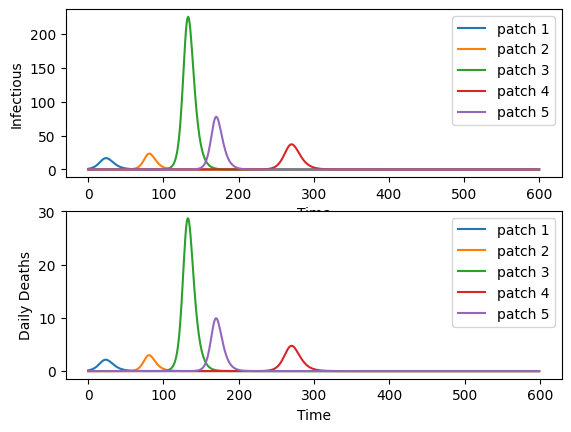

In [7]:
#Computing the daily deaths from the model output for a given patch
def daily_deaths(solution_model: dict, patch: int, T_inf: int, T_sup: int) -> list[float]:
    assert T_inf >= 0, "t must be greater than 0"
    assert T_sup >= 0, "t must be greater than 0"
    cumulative_deaths = solution_model['D'][patch] # list of floats         
    return [cumulative_deaths[t+1] - cumulative_deaths[t]
                for t in range(T_inf, T_sup)]

# Plotting the solution
def plot_SIRD_solution(model: dict, state: list[str] = ['S', 'I', 'R', 'D', 'DailyDeaths']):

    for key in state:
        if key not in model:
            raise ValueError(f"Invalid state: {key}")
        for i in range(model['n']):
            plt.plot(model['t'], model[key][i], label=f'{key} {i}')
    plt.xlabel('Time')
    plt.ylabel('Infectious')
    plt.title('SIRD model')
    #plt.legend(loc="upper center", mode ="expand",  ncol = 19, bbox_to_anchor=(0.5, -0.25))
    plt.show()

#Plotting the infected and daily deaths for the first five patches   
m = 19 # number of patches in the model
plt.subplot(211)
for i in range(5):
    plt.plot(model_dict['I'][i], label=('patch %s' %(i+1)))
plt.xlabel('Time')
plt.ylabel('Infectious')
pl.legend(loc=1)
plt.subplot(212)
for i in range(5):
    plt.plot(daily_deaths(model_dict, i, 0, 600), label=('patch %s' %(i+1)))
plt.xlabel('Time')
plt.ylabel('Daily Deaths')
pl.legend(loc=1)
plt.show()



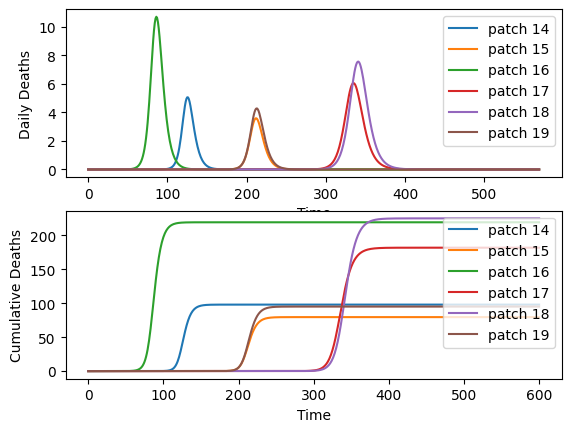

In [8]:
plt.subplot(211)
for i in range(13,19):
    plt.plot(daily_deaths(model_dict, i, 0, 570), label=('patch %s' %(i+1)))
plt.xlabel('Time')
plt.ylabel('Daily Deaths')
pl.legend(loc=1)
plt.subplot(212)
for i in range(13,19):
    plt.plot(model_dict['D'][i], label=('patch %s' %(i+1)))
plt.xlabel('Time')
plt.ylabel('Cumulative Deaths')
pl.legend(loc=1)
plt.show()